In [26]:
import os
import sys
sys.path.insert(0, '/Users/jlaura/github/autocnet')
from autocnet.graph import network
from autocnet.examples import get_path, available
from autocnet.fileio import io_gdal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Build the graph (This happens in the graph module)

In [2]:
G = network.CandidateGraph()
#Get a list of the available sample data
images = []
for fi in available('Apollo15'):
    d = get_path(fi)
    if '.json' in d:
        continue
    geods = io_gdal.GeoDataSet(get_path(fi))
    G.add_image(os.path.basename(geods.filename), geodataset=geods)
   

adjacency = {'AS15-M-0295_SML.png': [],
 'AS15-M-0296_SML.png':['AS15-M-0297_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png'],
 'AS15-M-0297_SML.png':['AS15-M-0296_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png', 'AS15-M-0300_SML.png'],
 'AS15-M-0298_SML.png':['AS15-M-0296_SML.png', 'AS15-M-0297_SML.png', 'AS15-M-0299_SML.png', 'AS15-M-0300_SML.png'],
 'AS15-M-0299_SML.png':['AS15-M-0296_SML.png', 'AS15-M-0297_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0300_SML.png'],
 'AS15-M-0300_SML.png':['AS15-M-0297_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png']}

#Add single edges to the graph
basename = 'AS15-M-0{}_SML.png'
for k,v in adjacency.items():
    for i in v:
        G.add_edge(k,i)

In [3]:
import networkx as nx #Only used to draw

nx.draw(G)
show()

/Users/jlaura/anaconda3/envs/autocnet/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


## On to the matching

In [4]:
import cv2
from scipy.misc import bytescale

/Users/jlaura/anaconda3/envs/autocnet/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [5]:
#Create the sift detector
sift = cv2.xfeatures2d.SIFT_create(10)

In [6]:
#We do not know which pairs might be good, so we need to process all of them.
#This computes for node with incidence 0...
for name, attributes in G.nodes_iter(data=True): #Returns a tuple
    geods = attributes['geodataset']
    #Get the first band of the array and add that data to the attributes
    image_array = bytescale(geods.readarray()) #OpenCV requires that the data be byte scaled...
    attributes['original_image'] = image_array
    keypoints, descriptors = sift.detectAndCompute(image_array, None)
    attributes['keypoints'] = keypoints
    attributes['descriptors'] = descriptors

## FLANN Matching

The idea here is to 'punch through' as many images as possible in a single go.  Basically, take a given image to be the query image, populate a KD-tree with all descriptors in neighbor images and perform the match. 

This will yield $n * k$ matches, where $n$ is the number of descriptors and $k$ is the user defined KNN parameter.

To use Lowe's ratio test, two matches per image are required, where a 'good match' is $i.distance < j.distance * 0.8$.  This requires $k >= node.incidence * 2$

To punch through, book keeping is going to be key.  The example below for three images illustrates how multiple images can be tied.  This is going to be a book keeping / efficiency issue.  By way of example:

296:
  * AS15-M-0297_SML.png 3 3 84.7584838867
  * AS15-M-0298_SML.png 3 6 133.540252686

297:
  * AS15-M-0296_SML.png 3 3 84.7584838867
  * AS15-M-0298_SML.png 3 6 90.1165924072

298:
  * AS15-M-0297_SML.png 6 3 90.1165924072
  * AS15-M-0296_SML.png 6 3 133.540252686

This is the same point, 'punched' through three images.

* How can this best be represented?
  * I need to know:
      * From Image
      * To Image
      * From Image Point ID
      * To Image Point ID
      * Distance
      
This is really the control network - in a raw, unfiltered form.  How best can a control network be represented...
* Assuming a brute force approach to generate this, what is the logic needed to extract this into a control network?

In [7]:
#This approach generates a new KD-Tree for each node.  What about just using one KD-Tree?
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
fl = cv2.FlannBasedMatcher(flann_params, {})

for node in ['AS15-M-0296_SML.png','AS15-M-0297_SML.png', 'AS15-M-0298_SML.png']:
    attributes = G.node[node]
    k = len(G.edges(node))
    #k = len(G.edges(node)) * 2 #To support ratio test
    query_descriptor = attributes['descriptors']
    training_descriptors = []

    image_lookup = {}
    for i, n in enumerate(nx.neighbors(G, node)):
        image_lookup[i] = n
        training_descriptors.append(G.node[n]['descriptors'])
    
    fl.add(training_descriptors)
    fl.train()
    
    matches = fl.knnMatch(query_descriptor, k=k)
    clipped_matches = []
    for m_list in matches:
        clipped_m = []
        visited = set()
        for m in m_list:
            if not m.imgIdx in visited:
                visited.add(m.imgIdx)
                clipped_m.append(m)
        clipped_matches.append(clipped_m)

    for c in clipped_matches:
        for i in c:
                print(image_lookup[i.imgIdx], i.queryIdx, i.trainIdx, i.distance)
        
    fl.clear()
    print

AS15-M-0297_SML.png 0 6 85.21736907958984
AS15-M-0298_SML.png 0 2 253.1975555419922
AS15-M-0298_SML.png 1 3 188.6478271484375
AS15-M-0297_SML.png 1 2 192.2784423828125
AS15-M-0299_SML.png 2 2 280.5405578613281
AS15-M-0297_SML.png 2 9 281.6096496582031
AS15-M-0298_SML.png 2 5 283.8714599609375
AS15-M-0297_SML.png 3 3 84.75848388671875
AS15-M-0298_SML.png 3 6 133.54025268554688
AS15-M-0297_SML.png 4 7 122.64175415039062
AS15-M-0298_SML.png 4 4 144.97586059570312
AS15-M-0298_SML.png 5 1 126.23786926269531
AS15-M-0297_SML.png 5 1 147.4788055419922
AS15-M-0297_SML.png 6 0 50.22947311401367
AS15-M-0298_SML.png 6 7 220.3474578857422
AS15-M-0298_SML.png 7 5 240.1853485107422
AS15-M-0297_SML.png 7 2 241.24053955078125
AS15-M-0299_SML.png 7 4 242.22509765625
AS15-M-0298_SML.png 8 5 182.67730712890625
AS15-M-0297_SML.png 8 2 201.5812530517578
AS15-M-0298_SML.png 9 1 150.5523223876953
AS15-M-0299_SML.png 9 1 162.28062438964844
AS15-M-0296_SML.png 0 6 50.22947311401367
AS15-M-0298_SML.png 0 3 219.8

### Performance
The training descriptors are packed into a list using append.  This is inefficient.  If the number of descriptors per image is capped, what about storing an ndarray for efficiency?  Something down the road.

In [8]:
print(G.nodes())

['AS15-M-0297_SML.png', 'AS15-M-0296_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png', 'AS15-M-0300_SML.png', 'AS15-M-0295_SML.png']


In [38]:
#This example builds a single KD-Tree and then removes self-neighbors
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
fl = cv2.FlannBasedMatcher(flann_params, {})


training_descriptors = []
image_lookup = {}
#Build a single KD-Tree
for i, n in enumerate(G.nodes()):
    training_descriptors.append(G.node[n]['descriptors'])
    image_lookup[i] = n

inverse_image_lookup = {v: k for k, v in image_lookup.items()}
fl.add(training_descriptors)
fl.train()

print("""QueryImage, QueryPoint, TreeImage, TreePoint, Distance""")

cnet = nx.DiGraph()
for node in G.nodes():
    iid = inverse_image_lookup[node]
    print(iid)
    k = len(G.edges(node)) + 1  #+1 becuase we know a self neighbor will exist.
    query_descriptor = G.node[node]['descriptors']
    
    matches = fl.knnMatch(query_descriptor, k=k)
    clipped_matches = []
    for m_list in matches:
        clipped_m = []
        visited = set()
        for m in m_list:
            if not m.imgIdx in visited and m.distance != 0 and not iid == m.imgIdx:
                visited.add(m.imgIdx)
                clipped_m.append(m)
        clipped_matches.append(clipped_m)

    #All the 5 entries are completely wrong - none of these overlap with 5
    for c in clipped_matches:
        for i in c:
            cnet.add_edge(*[(iid, i.queryIdx), (i.imgIdx, i.trainIdx)], weight=i.distance)
            print((iid, i.queryIdx), (i.imgIdx, i.trainIdx), i.distance)
    print('Processed')

QueryImage, QueryPoint, TreeImage, TreePoint, Distance
0
(0, 0) (1, 6) 50.22947311401367
(0, 0) (5, 4) 122.18019104003906
(0, 1) (2, 8) 102.72293090820312
(0, 1) (1, 5) 147.4788055419922
(0, 2) (2, 3) 64.52131652832031
(0, 2) (3, 2) 113.6309814453125
(0, 3) (1, 3) 84.75848388671875
(0, 3) (2, 6) 90.11659240722656
(0, 3) (5, 8) 156.40013122558594
(0, 4) (1, 6) 230.3193359375
(0, 4) (5, 4) 230.94154357910156
(0, 4) (2, 2) 239.3950653076172
(0, 5) (2, 0) 66.67832946777344
(0, 5) (1, 8) 212.7721710205078
(0, 6) (1, 0) 85.21736907958984
(0, 6) (5, 4) 238.07351684570312
(0, 6) (3, 4) 242.60667419433594
(0, 6) (2, 5) 243.74166870117188
(0, 7) (2, 4) 65.55150604248047
(0, 7) (1, 4) 122.64175415039062
(0, 8) (3, 9) 158.918212890625
(0, 8) (4, 8) 217.99771118164062
(0, 8) (1, 8) 223.17706298828125
(0, 9) (1, 1) 222.31959533691406
(0, 9) (3, 1) 225.2642822265625
(0, 9) (2, 5) 226.0420379638672
Processed
1
(1, 0) (0, 6) 85.21736907958984
(1, 0) (5, 4) 221.3662109375
(1, 0) (3, 4) 253.791259765625


In [32]:
for node in cnet.nodes():
    print(node)
    
print(cnet.node[(0,0)])

(5, 9)
(4, 7)
(1, 3)
(4, 8)
(3, 0)
(2, 8)
(3, 2)
(0, 7)
(5, 6)
(2, 6)
(1, 6)
(3, 7)
(0, 3)
(2, 5)
(5, 8)
(4, 0)
(1, 2)
(4, 9)
(3, 3)
(2, 9)
(2, 0)
(4, 4)
(1, 5)
(5, 0)
(0, 4)
(5, 3)
(4, 1)
(1, 1)
(0, 1)
(5, 4)
(0, 0)
(3, 6)
(4, 5)
(2, 2)
(1, 4)
(3, 9)
(0, 5)
(2, 1)
(4, 2)
(1, 0)
(0, 8)
(3, 5)
(2, 7)
(4, 6)
(5, 2)
(3, 1)
(0, 2)
(3, 8)
(0, 6)
(1, 8)
(4, 3)
(1, 7)
(0, 9)
(2, 3)
(3, 4)
(2, 4)
(1, 9)
{}


/Users/jlaura/anaconda3/envs/autocnet/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/jlaura/anaconda3/envs/autocnet/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


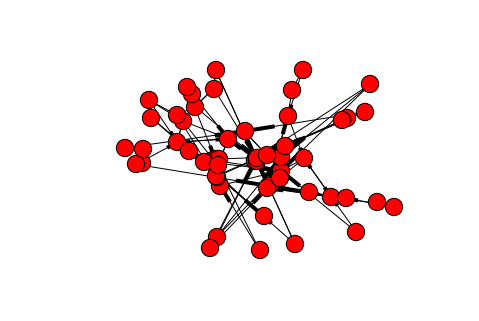

In [28]:
nx.draw(cnet)
show()